<div style="font-size: 32px;font-weight: bold;text-align: center">Face finder - Sigurnost Interneta</div>

This document contains code for Sigurnost Interneta (cro. _Internet Security_ ) course project "_Pretraživanje slika korištenjem lica kao parametar pretraživanja (OpenFace)_ ".

Goal of this project is to make a _proof-of-concept_ solution for searching some database by a given face. For example: _find all picutres where face X appears._

To achieve this goal, project relies heavily on DeepFace framework (https://github.com/serengil/deepface) that implements OpenFace algorithm (https://cmusatyalab.github.io/openface/) using Tensorflow.keras.

## DeepFace example

In [1]:
from deepface import DeepFace
import matplotlib.pyplot as plt

Using TensorFlow backend.


This next code block detects face in the provided image and aligns it horizontally.

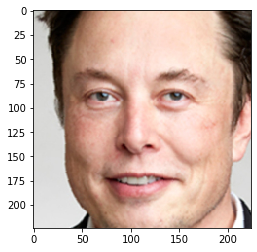

In [2]:
faca = DeepFace.detectFace("pics/search_faces/elon1.jpg")
plt.imshow(faca)

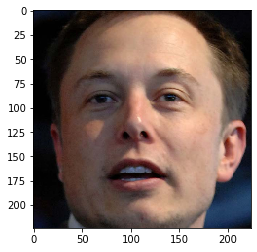

In [3]:
faca = DeepFace.detectFace("pics/db/elon4.jpg")
plt.imshow(faca)

Now we can just call `verify()` method and pass it two images that we want to compare. The result of this operation is python dictionary with comaprison data.

In [4]:
%%capture cap --no-display
result = DeepFace.verify("pics/search_faces/elon1.jpg", "pics/db/elon4.jpg")

If we check the `result` variable, we can see that it contains some comparison parameters. First one is boolean "verified" , that is `True` if the compared images contain the same face. 

Algorithm makes its decision with "distance" methric, that measures euclidian distance between face representations that it creates in the background. 

In [5]:
result

{'verified': True,
 'distance': 0.22090500593185425,
 'max_threshold_to_verify': 0.4,
 'model': 'VGG-Face',
 'similarity_metric': 'cosine'}

This comparison of 2 faces is the core concept of this project.
Rest of the work that needs to be done is to:

* Compare multiple images to one image of the face that is searched for.
* Comparing faces if there are multiple people in the image.

Next chapter starts with the latter.

## Multiple people in images

This chapter contains implementation of few functions that make detecting multiple people on images and processing them easier. Some of the tasks that need to be done are:

* __Detecting multiple faces__ - find if there are multiple faces in one image (similar to the DeepFace `detectFace()` function, but that one finds only one face in the image, to my knowledge at least...).


* __Crop faces__ - crop and save all found faces in the image to separate `.jpg` files. This is necessary because DeepFace `verify()` function only takes one face at a time for comparison.

In [6]:
import dlib
from skimage import io
import os
from PIL import Image
import shutil

In [7]:
def detect_faces(image):
    # Face detector object.
    face_detector = dlib.get_frontal_face_detector()
    # Finding faces in the image.
    detected_faces = face_detector(image, 1)
    # Drawing frames around found faces. Saving frame coordiantes in a list.
    face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]
    
    return face_frames

In [8]:
def remove_temp_dir():
    # Finds all subfolders in "pics/db/"
    subfolders = [ f.path for f in os.scandir("pics/db/") if f.is_dir() ]
    # Removes all subfolders and their content.
    for sub in subfolders:
        shutil.rmtree(sub)

## Putting it all together

Basic idea of this simple face search algorithm is:

1. Select face to search for in images
2. If image contains multiple faces:
    1. Save those faces to separate images.
3. Compare searched face to all faces in all images.


`find_images()` function implements this simple algorithm. 

In [9]:
%%capture cap --no-display
def find_images(image_path)->list:
    results = []
    
    base_dir = "pics/db/"
    all_pics = os.listdir(base_dir)

    for pic in all_pics:
        # Just the image name, without file extension.
        img_name = os.path.splitext(pic)[0]
        # Reading image from file.
        image = io.imread(base_dir + pic)
        # Detecting faces.
        detected_faces = detect_faces(image)
        print(pic)
        
        # If there is more than 1 face in image, create folder and place all faces in that folder. 
        if len(detected_faces) > 1:
            
            # Create new folder that will contain images of faces in the main image.
            os.mkdir(base_dir + img_name)
            
            # Crop faces from main image.
            for n, face_rect in enumerate(detected_faces):
                # Crop face from main image.
                face = Image.fromarray(image).crop(face_rect)
                plt.axis('off')
                # Make croped image.
                plt.imshow(face)
                # Save cropped image in newly created image folder, and name it with numbers.
                plt.savefig(base_dir+img_name+"/"+img_name+"_"+str(n)+".jpg")
            
            # Iterate through all faces in the main image.
            for p in os.listdir(base_dir + img_name):
                try:
                    # Compare all faces in main image to provided search image.
                    result = DeepFace.verify(image_path, base_dir + img_name + "/" + p)
                    if result["verified"] is True:
                        # If searched face is found in the image, save image name to `results` list.
                        results.append(pic)
                except:
                    pass
        # If there is only one face in the image, compare it to searched_image.
        elif len(detected_faces) == 1:
            try:
                result = DeepFace.verify(image_path, base_dir+pic)
                if result["verified"] is True:
                    results.append(pic)
            except:
                pass
        else:
            print("Something went wrong")
    
    # Remove all temporary created folders.
    remove_temp_dir()
    
    return results

In [26]:
import ipyplot

# Read all images from "search_results" and show them in matplotlib grid.
def show_results(search_results):
    imgs = []
    for pic in search_results:
        pic = Image.open("pics/db/"+pic)
        new_width = 300
        width_ratio = (new_width/float(pic.size[0]))
        height_size = int((float(pic.size[1])*float(width_ratio)))
        pic = pic.resize((new_width,height_size), Image.ANTIALIAS)

        imgs.append(pic)

    ipyplot.plot_images(imgs,img_width=150)

## Face Finder

To try ___Face finder___ out, use widgets bellow.

Select the name of the person whoose face you want to search for, wait a minute, and get all images that contain that face. Select "All" to see all faces that algorithm is searching through.

In [27]:
%%capture cap --no-display
from IPython.display import display
from ipywidgets import interact
import ipywidgets as widgets

# Selector widget.
selector = widgets.Select(
    options=['Dave Mustaine', 'Elon Musk', 'Joe Duplantier', 'All'],
    value='All',
    description='Pick one:',
    disabled=False
)

# Resizing functino that perserves aspect ratio of the image.
def show_img(path):
    pic = Image.open(path)
    new_width = 150
    width_ratio = (new_width/float(pic.size[0]))
    height_size = int((float(pic.size[1])*float(width_ratio)))
    pic = pic.resize((new_width,height_size), Image.ANTIALIAS)
    
    display(pic)
    
# Picking the person and displaying his image.
def func(choice):
    search_path = "pics/search_faces/"
   
    if choice == "Dave Mustaine":
        face_to_search = search_path + "dave1.jpg"
        show_img(face_to_search)
        print("Searching... dont touch anything for a minute or two...\n")
        search_results = find_images(face_to_search)
        print("\nResults:\n")
        show_results(search_results)
        
    elif choice == "Elon Musk":
        face_to_search = search_path + "elon1.jpg"
        show_img(face_to_search)
        print("Searching... dont touch anything for a minute or two...\n")
        search_results = find_images(face_to_search)
        print("\nResults:\n")
        show_results(search_results)
    
    elif choice == "Joe Duplantier":
        face_to_search = search_path + "joe1.jpg"
        show_img(face_to_search)
        print("Searching... dont touch anything for a minute or two...\n")
        search_results = find_images(face_to_search)
        print("\nResults:\n")
        show_results(search_results)
    
    elif choice == "All":
        face_to_search = search_path + "unknown.jpg"
        show_img(face_to_search)
        print("Searching... dont touch anything for a minute or two...\n")
        search_results = os.listdir("pics/db/")
        print("\nResults:\n")
        show_results(search_results)

In [28]:
%%capture cap --no-display
interact(func, choice=selector)

interactive(children=(Select(description='Pick one:', index=3, options=('Dave Mustaine', 'Elon Musk', 'Joe Dup…

<function __main__.func(choice)>